# Make paper figures from pre-analyzed data

Important note on ranks: 

In all analyses, ranks were calculated using the following defintions:
- for all hot day metrics, larger values (larger difference between hot and median days) were assigned lower ranks, such that the summer with the largest hot minus median difference had a value of 1
- for the number of cold days, similarly the largest value had a rank of 1
- in order to use these two defintions, the values of the metrics were negated before calculating ranks using the xarray rank function
- for cold day metrics, smaller values (which will be more negative) were assigned lower ranks

In this definition, moving towards a lower rank for both hot and cold tails indicated a stretching of the tails.

However, the visualization of this defintion led to confusion, because (for hot days), decreases in ranks were associated with more extreme heat. 

In the below figures, therefore, all hot day ranks have been redefined such that a rank of 1 maps to (for a 65 year dataset) a rank of 65, and an increase in rank indicates faster warming of heat extremes.

Cold day ranks are not redefined, and a positive trend indicates a smaller difference between cold and median days, e.g. faster warming of the lower tail.

This change in definition occurred after analyzing all CMIP6 output, hence the choice to post facto adjust the ranks rather than re-run everything.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summer_extremes.utils import *
from helpful_utilities.data_proc import get_trend_array
from helpful_utilities.stats import p_value_from_synthetic_null_data

import numpy as np
import xarray as xr
from glob import glob
import os
import datetime
import calendar

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
import matplotlib as mpl
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import string

%matplotlib inline

In [3]:
procdir = '/home/data/projects/summer_extremes/proc'
figdir = '/home/kmckinnon/summer_extremes/figs/revised'
cmip6_dir = '/home/data/CMIP6'

alpha_fdr = 0.05
regions = 'Global', 'NH', 'tropics', 'SH'
tropics_bound = 10
nsamples = 1000000  # number of time series to make for null distributions
percentile_width = 5  # half-width for definition of hot, cold, average days
percentile_base = np.array([5, 50, 95])  # middle of windows for temperature percentiles 
land_cutoff = 0.5  # land is anything with a land fraction greater than this
tails = 'hot', 'cold'

ERA5_tname = 't2m_x'
GHCND_tname = 'TMAX'
CMIP_tname = 'tasmax'
scenarios = 'hist', 'ssp370'

trend_normalizer = 65  # all trends shown as per 65 years 

hist_year1 = 1958
hist_year2 = 2023
ssp370_year1 = 2024
ssp370_year2 = 2099

sat_year1 = 1979

lower_lat = -60
upper_lat = 80

metrics_to_plot = 'seasonal_max', 'seasonal_min'
long_names = 'seasonal maximum', 'seasonal minimum'

# For plots
labelsize = 12
fontsize = 14
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.PlateCarree(central_longitude=0)
letters = list(string.ascii_lowercase)

lat_avg_degrees = 3  # Longitudinal averages will be smoothed by this many gridboxes (= degrees)

sec_per_day = 60*60*24

# Get land mask (excluding Greenland)
is_land = get_mask_land_Greenland()
# Subset to domain
is_land = is_land.sel(lat=slice(lower_lat, upper_lat))

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
No module named 'numpy.typing'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Load temperature rank data for all observational datasets

In [14]:
rank_suffix = ('_ERA5', '_SEB', '_chirts', '_ghcnd', '_ERA5_satera', '_SEB_satera', '_ghcnd_satera')

# Standard ERA5
fname_ERA5 = 'ranks_ERA5_t2m_x_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_ERA5 = xr.open_dataset('%s/%s' % (procdir, fname_ERA5))

# Surface energy balance
fname_SEB = 'T_SEB_ranks_1958-2023.nc'
ds_ranks_SEB = xr.open_dataset('%s/%s' % (procdir, fname_SEB))

# CHIRTS
fname_chirts = 'ranks_CHIRTS_Tmax_years-1983-2016_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_chirts = xr.open_dataset('%s/%s' % (procdir, fname_chirts))

# GHCND
fname_ghcnd = 'ranks_GHCND_TMAX_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_ghcnd = xr.open_dataset('%s/%s' % (procdir, fname_ghcnd))

# Satellite era analysis version (all below)
start_year_satera = 1979

# ERA5 + satellite era
fname_ERA5_satera = 'ranks_ERA5_t2m_x_years-%04i-2023_warm-season_2x45-days_lat-60-80.nc' % start_year_satera
ds_ranks_ERA5_satera = xr.open_dataset('%s/%s' % (procdir, fname_ERA5_satera))

# SEB + satellite era
fname_SEB_satera = 'T_SEB_ranks_%04i-2023.nc' % start_year_satera
ds_ranks_SEB_satera = xr.open_dataset('%s/%s' % (procdir, fname_SEB_satera))

# GHCND + satellite era
fname_ghcnd_satera = 'ranks_GHCND_TMAX_years-%04i-2023_warm-season_2x45-days_lat-60-80.nc' % start_year_satera
ds_ranks_ghcnd_satera = xr.open_dataset('%s/%s' % (procdir, fname_ghcnd_satera))

# As noted above, we need to redefine all the ranks for the hot metrics so that high numbers = 
# greater deviations from the median
datasets = [eval('ds_ranks%s' % rs) for rs in rank_suffix]

for ds in datasets:
    ds = swap_hot_ranks(ds)

# Load and pre-process CMIP rank data to regional averages

In [15]:
savename = fname_ERA5.replace('ERA5', 'CMIP6_avgs').replace(ERA5_tname, CMIP_tname)
# both scenarios in one file
savename = savename.replace('_years-1958-2023', '')
savename = '%s/%s' % (procdir, savename)

if os.path.isfile(savename):
    cmip_avg_vals_hist_ssp = xr.open_dataset(savename)
else:
    cmip_avg_vals_hist_ssp = []
    for period in scenarios:

        y1 = eval('%s_year1' % period)
        y2 = eval('%s_year2' % period)
        
        cmip_str = fname_ERA5.replace('ERA5', '*').replace(ERA5_tname, CMIP_tname)
        cmip_str = cmip_str.replace('1958-2023', '%04i-%04i' % (y1, y2))
        cmip_rank_files = sorted(glob('%s/%s' % (procdir, cmip_str)))
        if period == 'hist':  # append ERA5
            cmip_rank_files = cmip_rank_files + ['%s/%s' % (procdir, fname_ERA5)]

        cmip_avg_vals = [] 
        mvs = []

        for c in cmip_rank_files:
            # Load ranks for one CMIP simulation
            ranks_all = xr.open_dataset(c)
            # Swap the hot ranks as noted above
            ranks_all = swap_hot_ranks(ranks_all)
            
            mv = c.split('/')[-1].split('_')[1]
            this_model = '-'.join(mv.split('-')[:-1])

            # Two sanity checks that all analysis happened correctly
            # check that all years are present
            years_correct = ((ranks_all.year.min() == y1 + 1) & 
                             (ranks_all.year.max() == y2))
            if not years_correct:
                print('%s does not have full time span' % mv)
                continue

            # check that the number of lats & lons match the landmask
            if mv != 'ERA5':
                mask_name = glob('%s/fx/sftlf_fx_%s*.nc' % (cmip6_dir, this_model))[0]
                lsmask = xr.open_dataset(mask_name)['sftlf']
                lsmask = lsmask.sel(lat=slice(lower_lat, upper_lat))
                lats_lons_correct = ((len(lsmask.lat) == len(ranks_all.lat)) & 
                                     (len(lsmask.lon) == len(ranks_all.lon)))
                if not lats_lons_correct:
                    print('%s does not have correct lats/lons' % mv)
                    continue
            
            # From the gridded fields, calculate the regional averages
            avg_vals = calc_regional_averages(ranks_all, regions)
            cmip_avg_vals.append(avg_vals)
            mvs.append(mv)

        cmip_avg_vals = xr.concat(cmip_avg_vals, dim='model-variant')
        cmip_avg_vals['model-variant'] = list(mvs)
        cmip_avg_vals_hist_ssp.append(cmip_avg_vals)
    cmip_avg_vals_hist_ssp = xr.concat(cmip_avg_vals_hist_ssp, dim='scenario')
    cmip_avg_vals_hist_ssp['scenario'] = list(scenarios)
    
    cmip_avg_vals_hist_ssp.to_netcdf(savename)

## Figure 1: Maps and time series of ERA5 ranks (hot and cold), as well as time series for the predictions from the surface energy balance framework

Required inputs:
- ERA5 ranks
- SEB ranks

seasonal_max
0.7 percent of land has sig positive trend
1.0 percent of land has sig negative trend
Pearson correlation between trend maps: 0.28
seasonal_min
0.6 percent of land has sig positive trend
4.0 percent of land has sig negative trend
Pearson correlation between trend maps: 0.32
slope = 0.01, pval = 0.678, sig = False (Global seasonal_max)
slope = 0.00, pval = 0.986, sig = False (NH seasonal_max)
slope = 0.02, pval = 0.294, sig = False (tropics seasonal_max)
slope = 0.04, pval = 0.056, sig = False (SH seasonal_max)
slope = -0.07, pval = 0.000, sig = True (Global seasonal_min)
slope = -0.06, pval = 0.001, sig = True (NH seasonal_min)
slope = -0.18, pval = 0.000, sig = True (tropics seasonal_min)
slope = -0.12, pval = 0.000, sig = True (SH seasonal_min)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


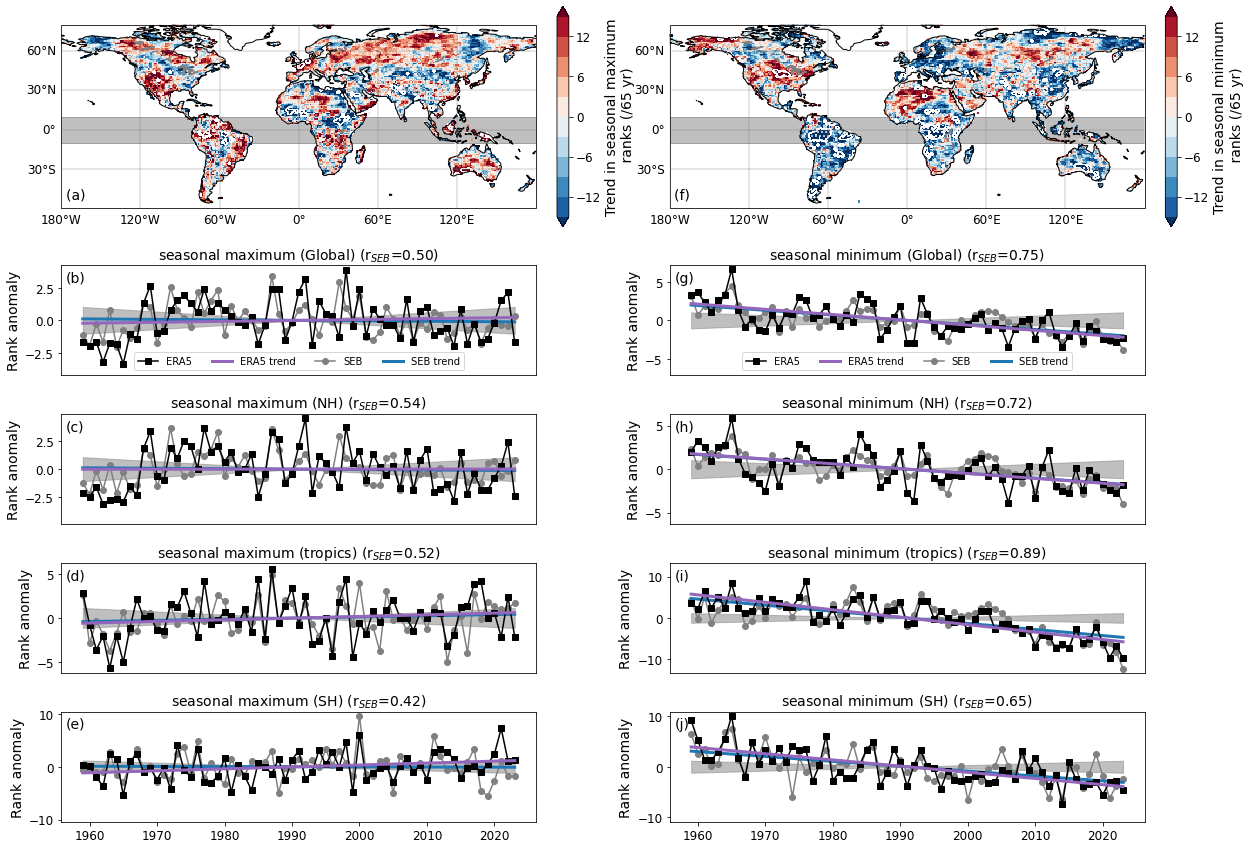

In [20]:
figname = 'fig01.pdf'

make_rank_plots(ds_ranks_ERA5.copy(), 'ERA5', metrics_to_plot, long_names, figname, nsamples,
                alpha_fdr, is_land, procdir, figdir,
                ds_ranks2=ds_ranks_SEB.copy(), rank2name='SEB', make_map_rank2=False,
                **{'legend_labels': list(('ERA5', 'ERA5 trend', 'SEB', 'SEB trend'))})

# Figure 2: Surface energy balance results using ERA5 only

Required inputs:
- Relative trends in surface energy budget terms in ERA5
- Relative trends in precipitation in ERA5

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Correlation, hot tail, T1 vs T2: -0.14
Correlation, hot tail, T1 vs total: 0.30
Correlation, hot tail, T1 vs precip: -0.23
Correlation, hot tail, T2 vs total: 0.90
Correlation, hot tail, T2 vs precip: -0.20
Correlation, hot tail, total vs precip: -0.30
Correlation, cold tail, T1 vs T2: 0.40
Correlation, cold tail, T1 vs total: 0.72
Correlation, cold tail, T1 vs precip: -0.45
Correlation, cold tail, T2 vs total: 0.92
Correlation, cold tail, T2 vs precip: -0.46
Correlation, cold tail, total vs precip: -0.53


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


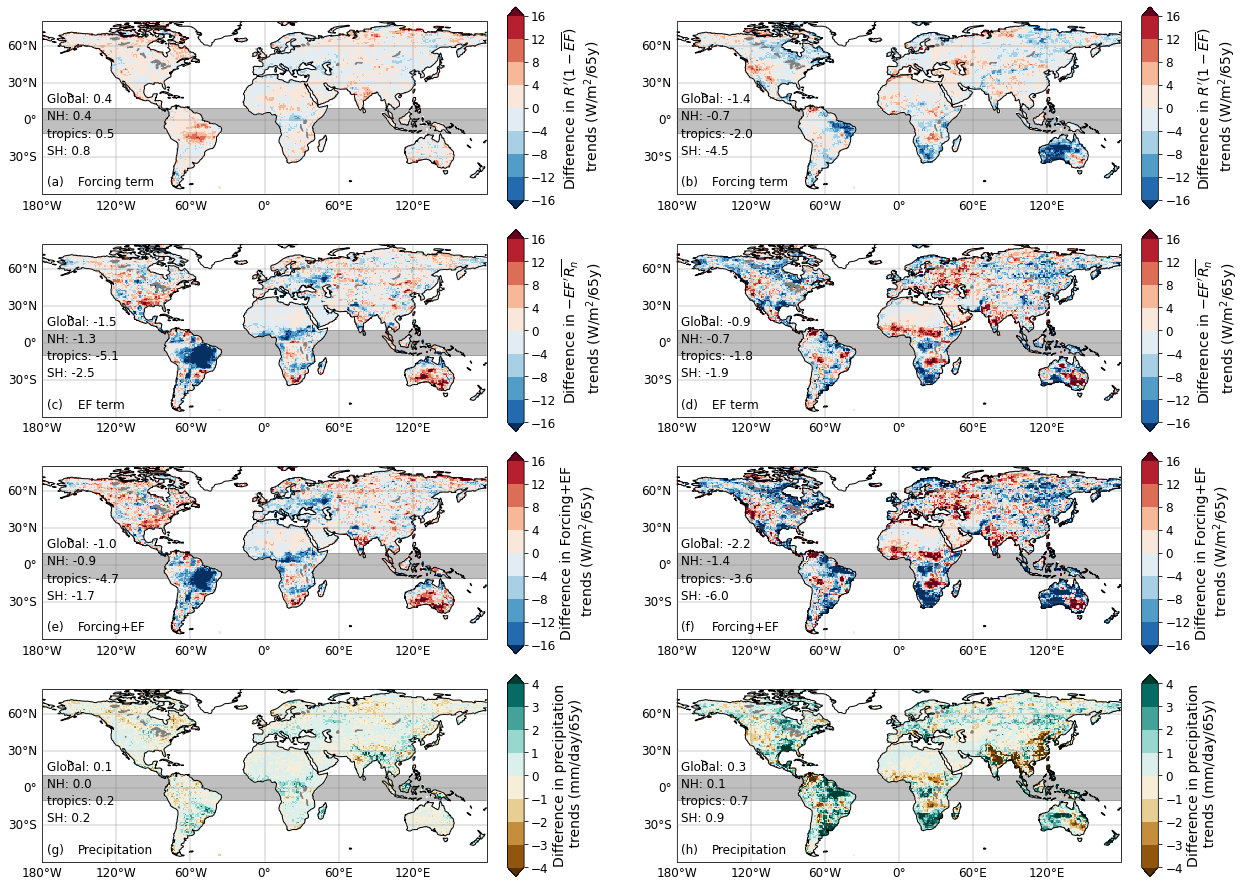

In [8]:
figname = 'fig02.pdf'
terms = 'T1', 'T2', 'total', 'precip'
tail_dict = {'hot': np.max(percentile_base), 'cold': np.min(percentile_base)}

# Which year to start the SEB analysis?
SEB_start_year = hist_year1

f_SEB = '%s/SEB_relative_trends_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                       SEB_start_year, hist_year2)

SEB_rel_trends = xr.open_dataset(f_SEB)

if SEB_start_year == sat_year1:
    # For precipitation, use average across many datasets
    pr_datasources = 'ERA5', 'CHIRPS', 'CPC', 'GPCC', 'PERSIANN', 'MSWEP'
    precip_rel_trends = combine_pr_datasets(pr_datasources, procdir, percentile_width, sat_year1)
elif SEB_start_year == hist_year1: 
    # Use only ERA5
    f_precip = '%s/ERA5_precip_relative_stats_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                                     SEB_start_year, hist_year2)
    precip_rel_trends = xr.open_dataset(f_precip)

make_SEB_plots(SEB_rel_trends, precip_rel_trends, terms, tail_dict, figname, figdir)
compare_maps(SEB_rel_trends, precip_rel_trends, terms, tail_dict)

# Figures 3 and 4: CMIP6 dot plots

There are 162 sims less than ERA5
There are 166 sims less than ERA5
There are 139 sims less than ERA5
There are 149 sims less than ERA5


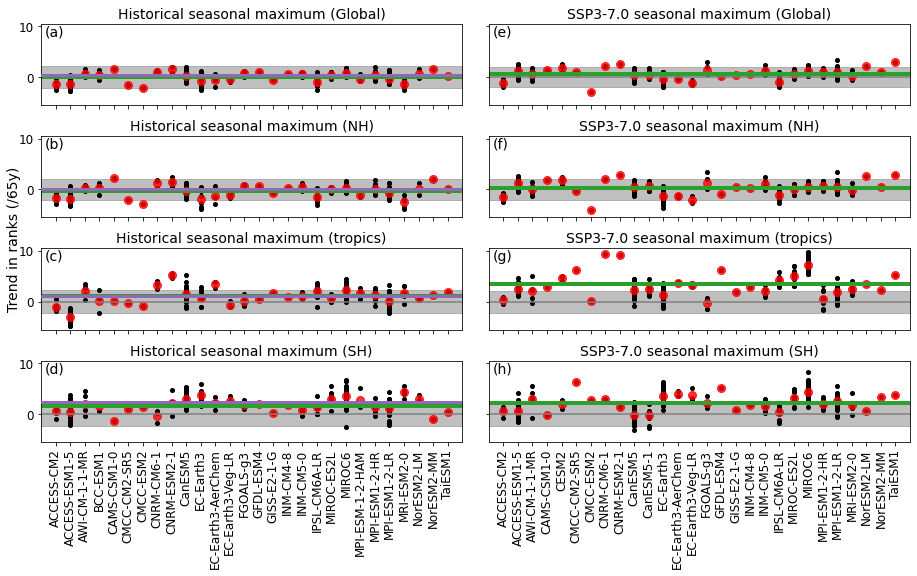

pval = 0.968, sig = False (Global hist)
pval = 0.779, sig = False (NH hist)
pval = 0.354, sig = False (tropics hist)
pval = 0.186, sig = False (SH hist)
pval = 0.497, sig = False (Global ssp370)
pval = 0.746, sig = False (NH ssp370)
pval = 0.002, sig = True (tropics ssp370)
pval = 0.049, sig = False (SH ssp370)
There are 0 sims less than ERA5
There are 1 sims less than ERA5
There are 0 sims less than ERA5
There are 0 sims less than ERA5


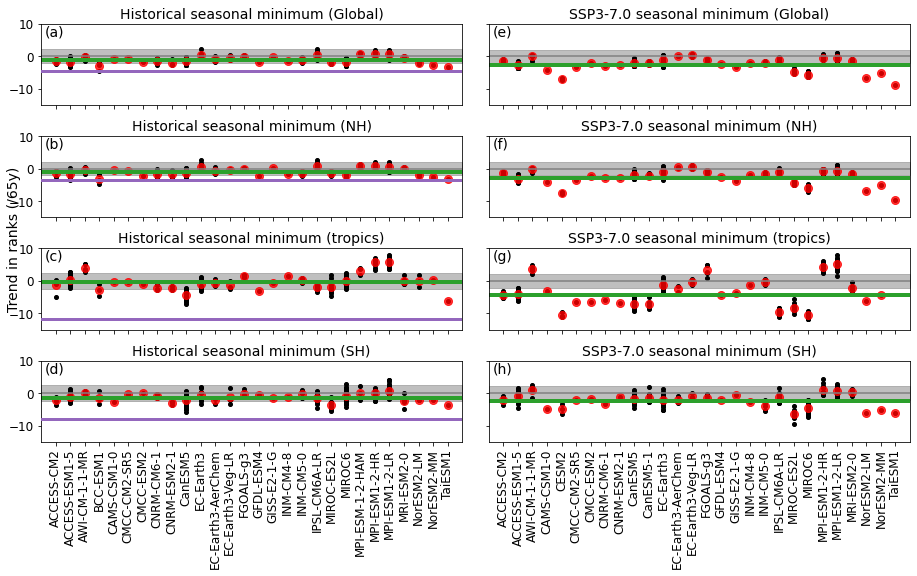

pval = 0.300, sig = False (Global hist)
pval = 0.330, sig = False (NH hist)
pval = 0.785, sig = False (tropics hist)
pval = 0.275, sig = False (SH hist)
pval = 0.006, sig = True (Global ssp370)
pval = 0.005, sig = True (NH ssp370)
pval = 0.000, sig = True (tropics ssp370)
pval = 0.038, sig = False (SH ssp370)


In [24]:
long_scenarios = 'Historical', 'SSP3-7.0'


pvals = []
obs_pvals = []
for m_ct, metric in enumerate(metrics_to_plot):
    
    ncols = len(scenarios)
    nrows = len(regions)

    fig, axes = plt.subplots(figsize=(6.4*ncols, 1.6*nrows), ncols=ncols, nrows=nrows, sharey=True)
    fig.tight_layout(h_pad=1)

    letter_ct = 0
    pvals_EM = []
    
    for s_ct, scenario in enumerate(scenarios):
    
        for r_ct, region in enumerate(regions):
            
            ax = axes[r_ct, s_ct]
            
            beta, this_nyrs = get_trend_cmip(cmip_avg_vals_hist_ssp, metric, scenario, 
                                             region, trend_normalizer)

            # Pull out individual model names
            model_names = [d.split('-r')[0] for d in beta['model-variant'].data]
            model_names_unique = list(np.unique(model_names))
            
            # Remove ERA5 from the model names
            if 'ERA5' in model_names:
                model_names_unique.remove('ERA5')
                
            # For null samples, use dof from ERA5 for consistency
            dof = get_dof(ds_ranks_ERA5[metric].sel(lat=get_lats_for_region(region)))

            if scenario == 'hist':  # samples will be the same as ERA5
                null_name = 'ERA5_%s_%s' % (region, metric)
            else:
                null_name = '%s_%s_%s' % (scenario, region, metric)
                
            # Contains slope and intercept of linear trends
            null_samples = create_null_samples(dof, this_nyrs, nsamples, null_name, procdir)
            # Pull out slopes only
            null_slopes = null_samples.sel(degree=1)*trend_normalizer
            # Get 95% range 
            null_slopes_95 = np.percentile(null_slopes, (2.5, 97.5))

            # Plot null range
            ax.fill_between(np.arange(-1, len(model_names_unique) + 1), 
                            null_slopes_95[0], null_slopes_95[1], color='gray', alpha=0.5)

                        
            ax.set_xlim(-1, len(model_names_unique))

            # Plot trends in each model member, as well as sample ensemble mean
            em_trends = []

            for ct_m, m in enumerate(model_names_unique):
                this_model = np.isin(model_names, m)
                
                # Plot each simulation
                ax.plot(ct_m, beta.sel({'model-variant': this_model}).data[np.newaxis, :], 
                        '.k', markersize=8)
                
                # Plot the EM
                ax.plot(ct_m, beta.sel({'model-variant': this_model}).mean(), 'or', 
                        alpha=0.8, markersize=8)
                
                # Save the EM trends
                em_trends.append(beta.sel({'model-variant': this_model}).mean().data)
                
            # Get overall ensemble mean (across all ensemble means)
            EM_trend = np.mean(np.array(em_trends))

            # Format x-tick labels
            ax.set_xticks(np.arange(0, len(model_names_unique)))
            
            if region == 'SH':
                ax.set_xticklabels(model_names_unique, rotation=90, ha='center')
            else:
                ax.set_xticklabels([])
            ax.axhline(0, color='gray')
            
            # Estimate p-value of ensemble mean based on null samples
            this_pval = hu_stats.p_value_from_synthetic_null_data(EM_trend, null_slopes)
            pvals_EM.append(this_pval)

            # Plot overall ensemble mean
            ax.axhline(EM_trend, color='tab:green', lw=4)
            
            # Plot ERA5
            if 'ERA5' in model_names:
                ERA5_trend = beta.sel({'model-variant': 'ERA5'})
                not_ERA5 = beta.sel({'model-variant': ~np.isin(beta['model-variant'], 'ERA5')})
                model_trends = beta.sel({'model-variant': 'ERA5'})
                ax.axhline(ERA5_trend, color='tab:purple', lw=3, zorder=5)
                print('There are %i sims less than ERA5' % (np.sum(not_ERA5 <= ERA5_trend)))

            # Set title
            ax.set_title('%s %s (%s)' % (long_scenarios[s_ct], long_names[m_ct], regions[r_ct]),
                         fontsize=fontsize)
            ax.tick_params(labelsize=labelsize)
            ax.text(0.01, 0.85, '(%s)' % letters[letter_ct], transform=ax.transAxes, fontsize=fontsize)
            letter_ct += 1

            
    if 'min' in metric:
        # TaiESM is a major outlier and is affecting all the axis limits
        # Will note that it is cut off in the caption
        ax.set_ylim(-15, 10)
        
    fig.text(0, 0.5, 'Trend in ranks (/%sy)' % trend_normalizer, fontsize=fontsize, 
             va='center', rotation='vertical')
    plt.savefig('%s/fig0%i.pdf' % (figdir, (3 + m_ct)), dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print out significance based on FDR control in each plot
    pvals_ts = np.array(pvals_EM)
    pcut_ts = hu_stats.get_FDR_cutoff(xr.DataArray(pvals_ts), alpha_fdr=alpha_fdr)
    is_sig_ts = pvals_ts <= pcut_ts
    counter = 0
    for s_ct, scenario in enumerate(scenarios):
        for r_ct, region in enumerate(regions):
            print('pval = %0.3f, sig = %s (%s %s)' % (pvals_ts[counter], is_sig_ts[counter].astype(bool),
                                                      region, scenario))
            counter += 1

In [9]:
# Print out various CMIP metrics that we want
region = 'Global'
for scenario in scenarios:
    
    this_ts = cmip_avg_vals_hist_ssp[metric].sel(scenario=scenario, region=region)
    this_ts = this_ts.dropna(dim='model-variant', how='all')
    this_ts = this_ts.dropna(dim='year', how='all')
    
    model_names = [d.split('-r')[0] for d in this_ts['model-variant'].data]
    # Remove ERA5 from the model names
    if 'ERA5' in model_names:
        model_names.remove('ERA5')
        
    model_names_unique, nmembers = np.unique(model_names, return_counts=True)
    model_names_unique = list(model_names_unique)

    Nsims = len(model_names)
    Nmodels = len(model_names_unique)
    
    is_LE = nmembers >= 30
    
    NLEs = np.sum(is_LE)
    LE_names = np.array(model_names_unique)[is_LE]
    
    print(scenario)
    print('%i simulations across %i models; %i are large ensembles:' % (Nsims, Nmodels, NLEs))
    print(LE_names)

hist
262 simulations across 28 models; 4 are large ensembles:
['ACCESS-ESM1-5' 'CanESM5' 'MIROC6' 'MPI-ESM1-2-LR']
ssp370
316 simulations across 28 models; 5 are large ensembles:
['ACCESS-ESM1-5' 'CanESM5' 'EC-Earth3' 'MIROC6' 'MPI-ESM1-2-LR']


In [10]:
# Print out stats for paper

# Tropical future sims
metric = 'seasonal_max'
scenario = 'ssp370'
cutoff = 0

for region in ('tropics', 'SH'):
    this_beta, _ = get_trend_cmip(cmip_avg_vals_hist_ssp, metric, scenario, region, trend_normalizer)
    N = np.sum(this_beta > cutoff)
    print('%i simulations have positive trends (%s, %s, %s)' % (N, region, metric, scenario))

# Cold tail comparison
metric = 'seasonal_min'
scenario = 'ssp370'
for region in regions:
    # Get ERA5 value
    this_beta, _ = get_trend_cmip(cmip_avg_vals_hist_ssp, metric, 'hist', region, trend_normalizer)
    cutoff = this_beta.sel({'model-variant': 'ERA5'})
    this_beta, _ = get_trend_cmip(cmip_avg_vals_hist_ssp, metric, scenario, region, trend_normalizer)
    N = np.sum(this_beta < cutoff)
    print('%i simulations have trends less than ERA5 (%s, %s, %s)' % (N, region, metric, scenario))




299 simulations have positive trends (tropics, seasonal_max, ssp370)
260 simulations have positive trends (SH, seasonal_max, ssp370)
64 simulations have trends less than ERA5 (Global, seasonal_min, ssp370)
81 simulations have trends less than ERA5 (NH, seasonal_min, ssp370)
3 simulations have trends less than ERA5 (tropics, seasonal_min, ssp370)
1 simulations have trends less than ERA5 (SH, seasonal_min, ssp370)
